# Feature Importance with Random Forest

This is a modified notebook from the [FastAI Machine Learning Course Lesson 2 notebook](https://github.com/fastai/fastai/blob/master/courses/ml1/lesson2-rf_interpretation.ipynb) and using the data from [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales), an old Kaggle competition. The data was cleaned and pre-processed as per the [FastAI Deep Learning Course Lesson 3](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson3-rossman.ipynb). This notebook shows some of the ways random forest can be used to explore a dataset, which features are important and how to interpret a random forest model.

In [1]:
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import HTML
from fastai.structured import *
from fastai.column_data import *
from sklearn import metrics

/home/lyk/anaconda3/envs/fastai/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
path = '/home/lyk/Documents/datasets/kaggle/rossmann'

In [3]:
df_raw = pd.read_feather(f'{path}/joined')

In [4]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

n = len(df_raw); n

844338

In [5]:
dep = 'Sales'
df_raw = df_raw[cat_vars+contin_vars+[dep, 'Date']].copy()

In [6]:
for v in cat_vars: df_raw[v] = df_raw[v].astype('category').cat.as_ordered()

In [7]:
for v in contin_vars:
    df_raw[v] = df_raw[v].astype('float32')

In [8]:
df_raw = df_raw.set_index("Date")

`proc_df` replaces categories with their numeric codes, replaces missing values with median, splits the dependent variable and returns a dictionary of columns with missing values

In [9]:
df, y, nas = proc_df(df_raw, 'Sales')

In [10]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(df,y)
m.score(df,y)

CPU times: user 2min 18s, sys: 860 ms, total: 2min 19s
Wall time: 30.2 s


0.9840630276373247

In [11]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = int(len(df)*0.1)
n_train = len(df)-n_valid
X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)
raw_train, raw_valid = split_vals(df_raw, n_train)

X_train.shape, y_train.shape, X_valid.shape

((759905, 40), (759905,), (84433, 40))

Root Mean Square Percentage Error (RMSPE) is the metric used to evaluate the model in the Rossman Store Sales Kaggle competition.

In [12]:
def exp_rmspe(y_pred, targ):
    pct_var = (targ - y_pred)/targ
    return math.sqrt((pct_var**2).mean())

def print_score(m):
    res = [exp_rmspe(m.predict(X_train), y_train), exp_rmspe(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): 
        res.append(m.oob_score_)
    else: 
        res.append('NA')
    print(f'exp_rmspe of train:{res[0]},\nexp_rmspe of valid:{res[1]}, \nr2 of train:{res[2]}, \nr2 of valid:{res[3]}, \noob score:{res[4]}')

In [13]:
%%time
m=RandomForestRegressor(n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

/home/lyk/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


exp_rmspe of train:0.0951844354317791,
exp_rmspe of valid:0.26058718811412906, 
r2 of train:0.9843176045728476, 
r2 of valid:0.8841361749164515, 
oob score:0.8283598834823633
CPU times: user 2min 14s, sys: 1.46 s, total: 2min 16s
Wall time: 33.8 s


In [14]:
%%time
m=RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

exp_rmspe of train:0.13558872080263565,
exp_rmspe of valid:0.2503893701027163, 
r2 of train:0.9659150917858987, 
r2 of valid:0.8911415245711546, 
oob score:0.9083546907291733
CPU times: user 5min 3s, sys: 1.85 s, total: 5min 5s
Wall time: 1min 3s


Setting a leaf limit and sampling a subset of the features each time will make the model more generalizable. Couple this with increasing the number of estimators (trees), we were able to improve the model's score from 0.26 to 0.25.

In [15]:
fi = rf_feat_importance(m, df); fi[:10] #returns a sorted dataframe using the feature_importances_ method

,cols,imp
22,CompetitionDistance,0.188275
0,Store,0.162205
36,Promo,0.124468
13,State,0.074661
11,CompetitionOpenSinceYear,0.074009
1,DayOfWeek,0.045446
8,StoreType,0.044616
12,Promo2SinceYear,0.036645
9,Assortment,0.030999
16,Promo_fw,0.021935


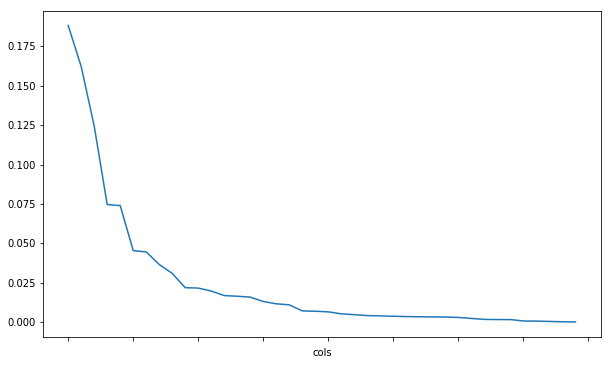

In [16]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [17]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

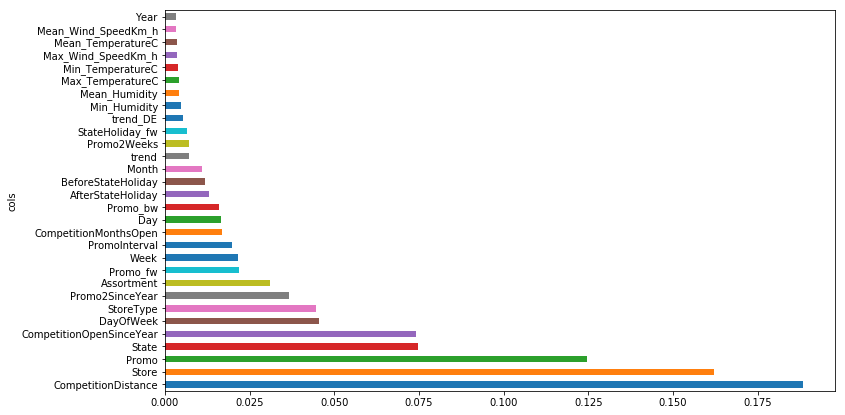

In [18]:
plot_fi(fi[:30]);

As shown above, features such as 'Competition Distance', 'Store' and 'Promo' are of much higher importance in determining the performance of the model. There are also some features such as temperature and humidity that are of relatively lower importance. We can remove them to simplify our model and reduce collinearity.

In [19]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

22

In [20]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_train)

In [21]:
m = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features=0.5,n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

exp_rmspe of train:0.14304805879487725,
exp_rmspe of valid:0.2451051454191559, 
r2 of train:0.9644805186679954, 
r2 of valid:0.892091521525679, 
oob score:0.9150274448686054


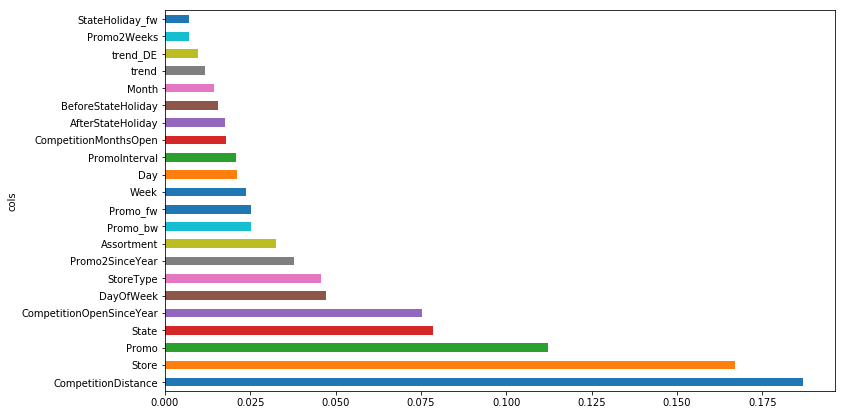

In [22]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

Removing some of the less important features reduces collinearity of the other features. As seen in the above chart, some features have become more and less important relative to other features when compared to the prior chart. For example, PromoInterval has become less important relative to other features like Day and Week. Our score has also improved from 0.250 to 0.245.

### Hierarchical clustering

Hierarchical clustering helps us to see whether there are any features that are closely related and that we can remove.

In [23]:
from scipy.cluster import hierarchy as hc

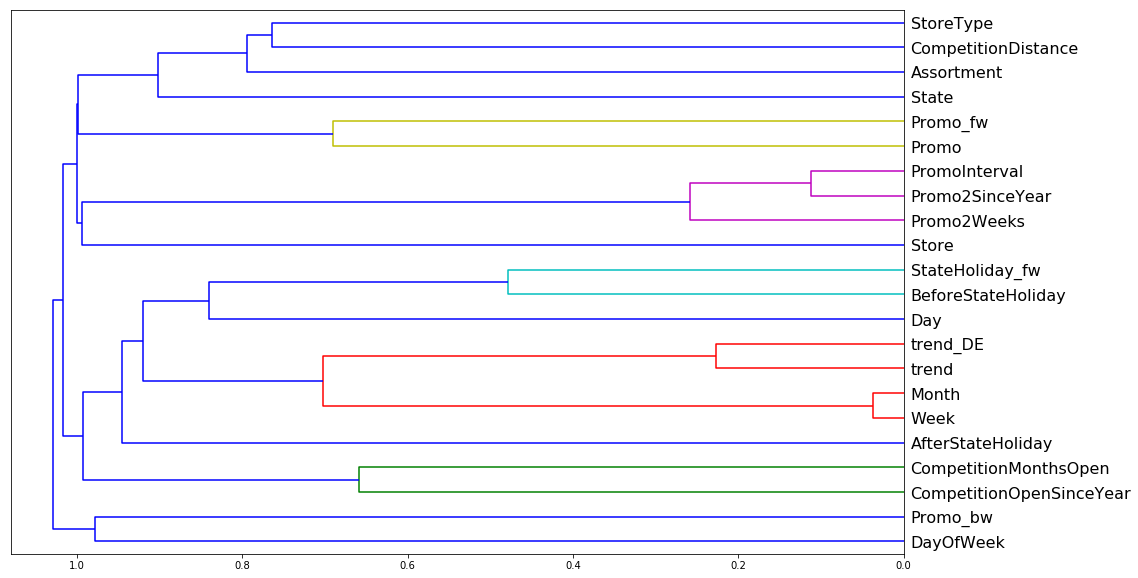

In [24]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

From the above chart, it would seem that the features 'Month' and 'Week', 'PromoInterval' and 'Promo2SinceYear' are relatively closely related. We can see whether removing one of them will improve our model by benchmarking a model without those features against the overall model with the Out-Of-Bag (oob) score.

In [25]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_train)
    m.fit(x, y_train)
    return m.oob_score_

In [26]:
get_oob(df_keep)

0.9088807254401349

In [27]:
for c in ('Month', 'Week', 'PromoInterval', 'Promo2SinceYear'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

/home/lyk/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Month 0.9072725756358992


/home/lyk/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Week 0.9054249195346126
PromoInterval 0.9052657813826417
Promo2SinceYear 0.9011896040545522


/home/lyk/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


As seen above, it seems that none of the features, when removed, improved the oob score at all. This likely means that removing one of the features would not improve our model's performance. We can validate this by removing the feature 'Month' and the model's performance did indeed get worse by about 0.04 as shown below.

In [30]:
to_drop = ['Month']
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_train)

In [31]:
#np.save('{path}keep_cols.npy', np.array(df_keep.columns))

In [32]:
#keep_cols = np.load('{path}keep_cols.npy')
keep_cols = np.array(df_keep.columns)

df_keep = df[keep_cols]

In [33]:
m = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

exp_rmspe of train:0.13741769681986699,
exp_rmspe of valid:0.24944927084735305, 
r2 of train:0.9626558148192744, 
r2 of valid:0.8935411593745537, 
oob score:0.9119088439216411


### Tree interpreter

[treeinterpreter](https://github.com/andosa/treeinterpreter) is a useful package that helps to explain the relationship between a particular row and its associated prediction.

In [33]:
from treeinterpreter import treeinterpreter as ti

In [34]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_train)

In [35]:
row = X_valid.values[None,0]; row

array([[2090.,  148.,    0.,    1.,   16.,    2.,    1.,    1.,    2.,    0.,    4.,   25.,    2.,    1.,
           4.,  -29.,   68.,    1.,    1.,   59.]], dtype=float32)

In [36]:
prediction, bias, contributions = ti.predict(m, row)

In [38]:
idxs = np.argsort(contributions[0])

In [39]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('Promo', 0.0, -964.4274951718004),
 ('CompetitionOpenSinceYear', 2008, -448.7819662541592),
 ('Assortment', 'a', -396.87670340994225),
 ('Promo_fw', 1.0, -68.7221945293175),
 ('trend_DE', 59.0, -64.47154072764057),
 ('CompetitionMonthsOpen', 24, -28.959847908095853),
 ('Month', 4, -22.93400432390781),
 ('BeforeStateHoliday', -29.0, -20.08604717987271),
 ('StateHoliday_fw', 0.0, -20.002649194816787),
 ('trend', 68.0, -15.039911676036718),
 ('StoreType', 'a', 12.88758151504051),
 ('Promo2Weeks', 0, 28.68562127945279),
 ('PromoInterval', nan, 56.99129900353027),
 ('DayOfWeek', 2, 82.61370420366126),
 ('Promo_bw', 3.0, 89.19600795789601),
 ('Day', 2, 114.20472454828945),
 ('CompetitionDistance', 2090.0, 625.307321492365),
 ('Store', 148, 654.4988780841703),
 ('AfterStateHoliday', 1.0, 1021.6895219481918),
 ('State', 'BE', 1147.4788321375572)]

For that specific row, we can see that having no promotion was the biggest factor in reducing sales while being in the state 'BE', being an 'after state holiday' and of store '148' were the biggest factors in increasing sales. In total, we can see that the above features gave an overall increase of 1783.25 to give a final prediction of 8775.25

In [41]:
contributions[0].sum()

1783.251131794565

In [37]:
prediction[0], bias[0]

(8775.24965079365, 6991.998518999084)